<a href="https://colab.research.google.com/github/NogaMudrik/text_from_flowers/blob/main/Create_Flowers_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create Flowers Test

functions

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 22 19:13:50 2023

@author: noga mudrik
"""
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import os


def checkEmptyList(obj):
    """
    Check if the given object is an empty list.

    Args:
        obj (object): Object to be checked.

    Returns:
        bool: True if the object is an empty list, False otherwise.

    """
    return isinstance(obj, list) and len(obj) == 0



def create_colors(len_colors, perm = [0,1,2], style = 'random', cmap  = 'viridis', seed = 0, reduce_green = 0.4):
    """
    Create a set of discrete colors with a one-directional order
    Input:
        len_colors = number of different colors needed
    Output:
        3 X len_colors matrix decpiting the colors in the cols
    """
    np.random.seed(seed)
    if style == 'random':
        colors = np.random.rand(3, len_colors)
        colors[1] = colors[1]*reduce_green
    else:
        cmap = plt.get_cmap(cmap)
        # Create an array of values ranging from 0 to 1 to represent positions in the colormap
        positions = np.linspace(0, 1, len_colors)

        colors = [cmap(pos) for pos in positions]

    return colors


def to_create_plot_of_cs(c, mat, colors = [], cmap  = 'viridis', epsilon = 1e-9, fig = [], ax = [], wind = 3, len_curve = 0.01,
                         plot_curves = False, closed_loop = True, seed = 0):
    """
    Create a plot of curves in 2D using control points and coefficients.

    Parameters:
    - c (numpy.ndarray): Coefficients representing the control points of the curves.
    - mat (numpy.ndarray): Matrix representing the control points of the curves.
    - colors (list, optional): List of colors for the curves. If not provided, random colors will be generated.
    - cmap (str, optional): Colormap for generating random colors. Default is 'viridis'.
    - epsilon (float, optional): A small value used for numerical stability. Default is 1e-9.
    - fig (matplotlib.figure.Figure, optional): Matplotlib figure for plotting. If not provided, a new figure is created.
    - ax (matplotlib.axes.Axes, optional): Matplotlib axes for plotting. If not provided, new axes are created.
    - wind (int, optional): Window size for the control points. Default is 3.
    - len_curve (float, optional): Length of the curve segments. Default is 0.01.
    - plot_curves (bool, optional): Whether to plot the curves as lines. Default is False.
    - closed_loop (bool, optional): Whether to close the curve loops. Default is True.
    - seed (int, optional): Seed for random color generation. Default is 0.

    Raises:
    - ValueError: If the size of c and mat do not match or if the dimensions of mat are not supported.

    Returns:
    - matplotlib.figure.Figure: The matplotlib figure containing the plot.
    - matplotlib.axes.Axes: The matplotlib axes containing the plot.
    """

    if checkEmptyList(colors):
        colors = create_colors(c.shape[0], style = 'random', cmap = cmap, seed = seed)
        colors = [colors[:,i] for i in range(colors.shape[1])]
    c = np.abs(c)

    if len(mat.flatten()) == np.max(mat.shape):
        mat = mat.reshape((1,-1))

    if len(c.flatten()) == np.max(c.shape):
        c = c.reshape((1,-1))



    if mat.shape[1] != c.shape[1]:
        raise ValueError('size must match')

    if mat.shape[0] == 1 or len(mat.flatten()) == np.max(mat.shape):
        if checkEmptyList(ax):
            fig, ax = plt.subplots()
        x = np.arange(len(mat.flatten()))
        y = mat.flatten()
        y_end = y + c
        ys = np.vstack([y, y_end])
        [ax.fill([x_i, x_i, x[i+1], x[i+1]], [ys[0,i], ys[1,i], ys[1,i+1], ys[0,i+1]], color = colors[0], alpha = 0.2) for i, x_i in enumerate(x[:-1])]


    elif mat.shape[0] == 2:
        if checkEmptyList(ax):
            fig, ax = plt.subplots()

        x = mat[0].flatten()
        y = mat[1].flatten()

        for dim_c in range(c.shape[0]):


            m_inv = np.vstack([-np.diff(y) , np.diff(x)])
            m_inv_l2 = np.sum(m_inv**2,0)**0.5
            m_inv = len_curve *m_inv/m_inv_l2.reshape((1,-1))
            m_inv = np.hstack([m_inv, m_inv[:,-1].reshape((-1,1)) ])

            endings = np.vstack([x,y])+ m_inv*np.repeat(c[dim_c].reshape((1,-1)), 2, axis = 0)


            starts = np.vstack([x,y])

            if plot_curves:
                [ax.plot([starts[0][i], endings[0][i]],[starts[1][i], endings[1][i]],
                         c = colors[dim_c] , alpha = 0.5)
                 for i in range(starts.shape[1])]



            [ax.fill([starts[0,i], starts[0,i+1], endings[0,i+1], endings[0,i]], [starts[1,i], starts[1,i+1], endings[1,i+1], endings[1,i]],
                       color = colors[dim_c], alpha = 1) for i in np.arange(endings.shape[1]-1)]
            if closed_loop:
                ax.fill([starts[0,-1], starts[0,0], endings[0,0], endings[0,-1]], [starts[1,-1], starts[1,0], endings[1,0], endings[1,-1]],
                           color = colors[dim_c], alpha = 1)


            x = endings[0]
            y = endings[1]

            remove_edges(ax)
    elif mat.shape[0] == 3:
        pass

    else:

        raise ValueError('cannot plot high dims')



def remove_edges(ax, include_ticks = False, top = False, right = False, bottom = False, left = False):
    """
    Remove edges and ticks from a matplotlib axes.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes from which edges and ticks will be removed.
    - include_ticks (bool): If True, ticks will be removed as well.
    - top (bool): If True, remove the top edge.
    - right (bool): If True, remove the right edge.
    - bottom (bool): If True, remove the bottom edge.
    - left (bool): If True, remove the left edge.
    """
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    if not include_ticks:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])





def create_flower( stem_color = 'green', fig = [], ax = [],
    F = 509,     w = 0.002,    l = 0.4, center = (0,0), seed = 0, cos_max_c = 10, cos_max_c2 = 5, w_c_2 = 5, w_c = 8, fill_inside = True):

    """
    Create a flower-like plot with a stem and petals using control points and coefficients.

    Parameters:
    - stem_color (str, optional): Color of the stem. Default is 'green'.
    - fig (matplotlib.figure.Figure, optional): Matplotlib figure for plotting. If not provided, a new figure is created.
    - ax (matplotlib.axes.Axes, optional): Matplotlib axes for plotting. If not provided, new axes are created.
    - F (int, optional): Number of points for creating the flower petals. Default is 509.
    - w (float, optional): Width of the petals. Default is 0.002.
    - l (float, optional): Length of the petals. Default is 0.4.
    - center (tuple, optional): Center coordinates of the flower. Default is (0, 0).
    - seed (int, optional): Seed for random color generation. Default is 0.
    - cos_max_c (int, optional): Maximum value for the cosine function for the first set of coefficients. Default is 10.
    - cos_max_c2 (int, optional): Maximum value for the cosine function for the second set of coefficients. Default is 5.
    - w_c_2 (float, optional): Width factor for the second set of coefficients. Default is 5.
    - w_c (float, optional): Width factor for the first set of coefficients. Default is 8.
    - fill_inside (bool, optional): Whether to fill the inside of the flower. Default is True.

    Returns:
    - matplotlib.figure.Figure: The matplotlib figure containing the flower plot.
    - matplotlib.axes.Axes: The matplotlib axes containing the flower plot.
    """


    x_green = [-w + center[0], w+ center[0], w+ center[0], -w+ center[0]]
    rad = 0.05
    y_green = [-rad + center[1], -rad + center[1], -rad + center[1] - l, -rad + center[1] -l]
    mat = np.vstack([0.05*np.sin(np.linspace(0,np.pi*2,F)),0.05*np.cos(np.linspace(0,np.pi*2,F))]) + np.array(center).reshape((-1,1))

    ax.fill(x_green,y_green, color ='green')
    c = np.vstack([w_c*np.sin(np.pi*np.linspace(0,cos_max_c, F)),w_c_2*np.sin(np.pi*np.linspace(0,cos_max_c2, F))]) + 2
    if checkEmptyList(ax):
        fig, ax = plt.subplots(figsize = (7,8))
    to_create_plot_of_cs(c, mat, fig = fig, ax = ax, seed = seed)
    if fill_inside:
        ax.fill(mat[0], mat[1], color = 'lightpink', alpha = 0.6)




def create_flowers(num_flowers = 170, F_max = 500, F_min = 60,
    w_min = 0.002, w_max = 0.02, l_max = 0.4, l_min = 0.2,
    centers_min = -3, centers_max = 3, to_save = False, centers = [], fig = [], ax = [], name_save = ''):

    if checkEmptyList(centers):
        centers_min = -int(num_flowers/11)
        centers_min = int(num_flowers/11)
        centers = np.random.rand(num_flowers, 2 )*(- centers_min + centers_max) + centers_min
    if checkEmptyList(ax):
        fig, ax = plt.subplots(figsize = (22,5))
    random_rb = np.random.rand( num_flowers, 2)*0.3
    greens = np.hstack([np.ones((num_flowers, 1)), random_rb])


    num_dots = np.random.choice(np.arange(F_min, F_max), size = num_flowers)
    ws = np.random.rand(num_flowers)*(w_min - w_max) + w_min
    ls = np.random.rand(num_flowers)*(-l_min +  l_max) + l_min

    cos_max_cs = np.random.randint(2,6, size = num_flowers)
    cos_max_c2s = np.random.randint(4,10, size = num_flowers)
    w_c_2s = np.random.randint(4, 8, size = num_flowers)
    w_c_s = np.random.randint(2,12, size = num_flowers)
    for flower in range(num_flowers):
        cur_stem_color = greens[flower, :]
        cur_center = centers[flower,:]

        w_current = ws[flower]
        l = ls[flower]
        cos_max_c = cos_max_cs[flower]
        cos_max_c2 = cos_max_c2s[flower]
        w_c_2 = w_c_2s[flower]
        w_c = w_c_s[flower]

        create_flower(stem_color = cur_stem_color, fig = fig, ax = ax,  center = cur_center,
            F = num_dots[flower],
            w = w_current,
            l = l, seed = flower, cos_max_c = cos_max_c, cos_max_c2 = cos_max_c2, w_c_2 = w_c_2, w_c = w_c
            )


    if to_save:
        fig.tight_layout()
        plt.savefig('flowers_%d%s.png'%(num_flowers, name_save))
        plt.savefig('flowers_%d%s.svg'%(num_flowers, name_save))
        #plt.close()





def create_text_to_image(string = 'BRING THEM HOME!', yex = 0.1,  format_text = '.png', string_save = ''):
    if len(string_save) == 0:
        string_save = string
    fig, ax = plt.subplots(figsize = (len(string),1))
    ax.text(0, 0, string, fontsize = 50, fontweight = 'bold')
    ax.set_ylim([- yex, yex])
    fig.tight_layout()

    remove_edges(ax)
    string_valid = string_save.replace('$', '').replace(os.sep, '')
    plt.savefig('%s.%s'%(string_valid,  format_text) , bbox_inches="tight")



def load_and_convert_to_bw(file_path):
    # Open the image file
    image = Image.open(file_path)

    # Convert the image to grayscale
    image_bw = image.convert('L')

    # Convert the grayscale image to a NumPy array
    image_array = np.array(image_bw)

    return image_array


def find_text_locs(string, format_text = '.png', string_save = ''):
    if len(string_save) == 0:
        string_save = string

    string_valid = string_save.replace('$', '').replace(os.sep, '')
    if not os.path.exists('%s.%s'%(string_valid,  format_text)):
        create_text_to_image(string, string_save = string_save, format_text  = format_text )
        time.sleep(5)  # Pause for 5 seconds
    img_array = load_and_convert_to_bw('%s.%s'%(string_valid, format_text))
    is_text = img_array < 250
    #print(np.where(is_text))
    text_rows, text_cols  = np.where(is_text) # np.unravel_index(np.where(is_text)[0], img_array.shape )

    return text_rows, text_cols



def flowers_by_text(string ='BRING THEM HOME', num_flowers = 1030, F_max = 60, F_min = 20,
    w_min = 0.002, w_max = 0.02, l_max = 0.4, l_min = 0.2,
    centers_min = -3, centers_max = 3, to_save = True, fac = 0.1, w_back = False, format_text = '.png', string_save = ''):

    if len(string_save) == 0:
        string_save = string

    max_flowers = num_flowers

    text_rows, text_cols = find_text_locs(string,  format_text, string_save)
    text_rows = - text_rows
    if len(text_rows) > max_flowers:
        num_cur = len(text_rows)
        num_new = np.random.choice( np.arange( num_cur),  max_flowers  ) #np.linspace(0, num_cur - 1, max_flowers ).astype(int)

        text_rows_new = text_rows[num_new]

        text_cols_new = text_cols[num_new]
    else:
        num_flowers = len(text_rows)



    fig, ax = plt.subplots(figsize = (len(string)*2,4))
    if w_back:
        ax.scatter(text_cols*fac ,text_rows*fac, alpha = 0.2, color = 'green')

    string_valid = string_save.replace('$', '').replace(os.sep, '')
    create_flowers(num_flowers, F_max, F_min ,
        w_min, w_max, l_max, l_min,
        centers_min, centers_max, to_save, centers = np.vstack([text_cols_new ,text_rows_new ]).T*fac, fig = fig, ax = ax, name_save = string_valid + str(w_back))




# RUN EXAMPLE

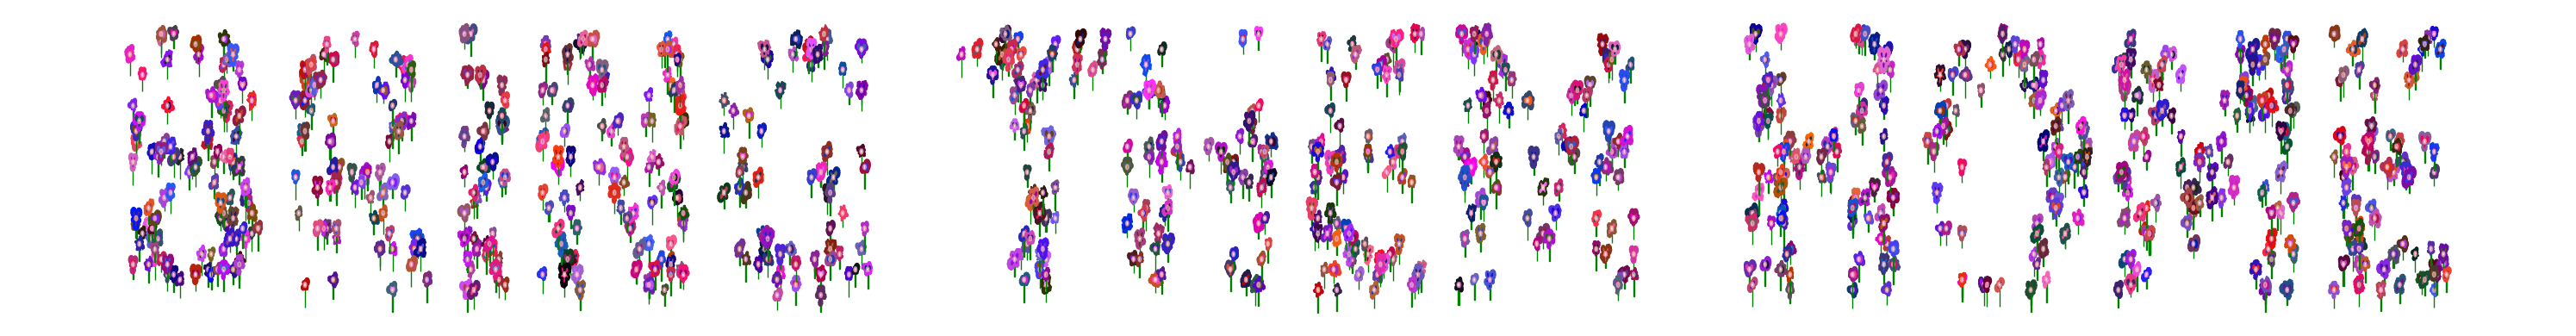

In [4]:
flowers_by_text()